# Get the Class names 

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

In [1]:
!wget 'https://raw.githubusercontent.com/XianNg24/XianNg24.github.io/main/sketcher/mini_classes.txt'

--2022-01-25 01:53:11--  https://raw.githubusercontent.com/XianNg24/XianNg24.github.io/main/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2384 (2.3K) [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]   2.33K  --.-KB/s    in 0s      

2022-01-25 01:53:11 (52.1 MB/s) - ‘mini_classes.txt’ saved [2384/2384]



Read the classes names 

In [2]:
!rm -rf data

In [3]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [4]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [5]:
!mkdir data

In [6]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [7]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/alarm%20clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ambulance.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/angel.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ant.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/arm.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/axe.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/backpack.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bandage.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/barn.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bi

# Imports 

In [2]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [3]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 2000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        # print(data.shape)
        data = data[0: max_items_per_class, :]
        # print(data.shape)
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [ ]:
print(len(x_train))

Show some random data 

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [1]:
from PIL import Image

x_train  = np.array([np.array(Image.fromarray(x.reshape(28,28)).resize([32,32])) for x in x_train])
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1).astype('float32')
# x_train = np.repeat(x_train, 3, -1)

x_test  = np.array([np.array(Image.fromarray(x.reshape(28,28)).resize([32,32])) for x in x_test])
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1).astype('float32')
# x_test = np.repeat(x_test, 3, -1)

NameError: ignored

In [33]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

TypeError: ignored

# The Model 

In [ ]:
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.applications.densenet import DenseNet121
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Input

base_model = DenseNet121(include_top=False, input_shape=(32, 32, 1), classes=301)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(301, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=1e-4, decay=1e-9), loss='categorical_crossentropy', metrics=['top_k_categorical_accuracy'])

print(model.summary())

In [10]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(128, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.Convolution2D(128, (3, 3), padding='same', activation= 'relu'))            
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Convolution2D(256, (3, 3), padding='same', activation= 'relu'))
model.add(layers.Convolution2D(256, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Convolution2D(512, (3, 3), padding='same', activation= 'relu'))
model.add(layers.Convolution2D(512, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Convolution2D(1024, (3, 3), padding='same', activation= 'relu'))
model.add(layers.Convolution2D(1024, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(301, activation='softmax')) 
# Train model
adam = tf.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=adam, 
              metrics=['accuracy', 'top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 256)       2

# Training 

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_top_k_categorical_accuracy', mode='max', patience=3)
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=1, epochs=10, callbacks=[callback],)

Epoch 1/10
1694/1694 [==============================] - 285s 158ms/step - loss: 2.2487 - accuracy: 0.4724 - top_k_categorical_accuracy: 0.7402 - val_loss: 1.7122 - val_accuracy: 0.5806 - val_top_k_categorical_accuracy: 0.8361
Epoch 2/10
1694/1694 [==============================] - 279s 165ms/step - loss: 1.4590 - accuracy: 0.6327 - top_k_categorical_accuracy: 0.8697 - val_loss: 1.4602 - val_accuracy: 0.6355 - val_top_k_categorical_accuracy: 0.8707
Epoch 3/10
1694/1694 [==============================] - 283s 167ms/step - loss: 1.2458 - accuracy: 0.6804 - top_k_categorical_accuracy: 0.8960 - val_loss: 1.3570 - val_accuracy: 0.6593 - val_top_k_categorical_accuracy: 0.8829
Epoch 4/10
1694/1694 [==============================] - 283s 167ms/step - loss: 1.0935 - accuracy: 0.7135 - top_k_categorical_accuracy: 0.9139 - val_loss: 1.2902 - val_accuracy: 0.6794 - val_top_k_categorical_accuracy: 0.8911
Epoch 5/10
1694/1694 [==============================] - 293s 173ms/step - loss: 0.9563 - accurac

# Testing 

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[2] * 100))

Test accuarcy: 88.99%


# Inference 

TypeError: ignored

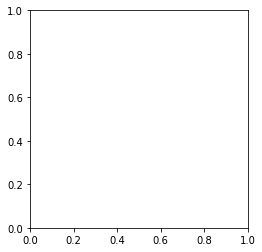

In [25]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [26]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [27]:
!pip install tensorflowjs 

     |████████████████████████████████| 77 kB 4.7 MB/s 


# Save and Convert 

In [28]:
model.save('keras.h5')

In [29]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Zip and Download 

In [30]:
!cp class_names.txt model/class_names.txt

In [31]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/group1-shard4of23.bin (deflated 7%)
  adding: model/group1-shard18of23.bin (deflated 7%)
  adding: model/group1-shard17of23.bin (deflated 7%)
  adding: model/group1-shard12of23.bin (deflated 7%)
  adding: model/group1-shard1of23.bin (deflated 7%)
  adding: model/group1-shard10of23.bin (deflated 7%)
  adding: model/group1-shard7of23.bin (deflated 8%)
  adding: model/group1-shard23of23.bin (deflated 7%)
  adding: model/group1-shard14of23.bin (deflated 7%)
  adding: model/group1-shard22of23.bin (deflated 7%)
  adding: model/group1-shard19of23.bin (deflated 8%)
  adding: model/group1-shard3of23.bin (deflated 7%)
  adding: model/group1-shard16of23.bin (deflated 7%)
  adding: model/group1-shard8of23.bin (deflated 7%)
  adding: model/group1-shard15of23.bin (deflated 7%)
  adding: model/group1-shard5of23.bin (deflated 7%)
  adding: model/group1-shard20of23.bin (deflated 8%)
  adding: model/group1-shard11of23.bin (deflated 7%)
  adding: model/group1-

In [32]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>